### Mean Reversion - (Pairs Trading)

- Long Pair: Long stock A and short stock B
- Short Pair: Short stock A and long stock B
- find high correlation asset pair (>0.8), make sure the correlation(positive or negative) is stationary over a long period of time
- ideally, want a highly negative correlation, so long side goes up, down side goes down to maximize the profits
- in short, it is like a mean reversion strategy of FX pairs
- Based on the assumption the ratio will have mean reversion nature over the long term, when ratio(price A/price B) of the pair deviates from the long term average, long/short the pair accordingly
- Define the degree of deviation from the mean by standard deviation, aka z-scores
- Stationary data refers to the time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.
- reference: https://towardsdatascience.com/stationarity-assumption-in-time-series-data-67ec93d0f2f

- Cointegration test: A technique used to find a potential correlation in a time series (long term)
- Determines if the spread between the two assets are constant over time.
- Null Hypothesis: Spread between series are non-stationary.
- 
#### Another way to test stationarity of time series data is ADF as below:
- Uses the augmented Engle-Granger two-step cointegration test.
- reference: https://corporatefinanceinstitute.com/resources/knowledge/other/cointegration/ 
- Time Series analysis: https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- ADF test: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
- However, this is a very common mistake analysts commit with this test. That is, if the p-value is less than significance level, people mistakenly take the series to be non-stationary.

### 1. Build up Data Frame of Stock Data

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

# 1. build df of Adj Close data for the stocks
end = datetime(2022,1,1)
start = datetime(2021,1,1)
tickers = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","TWTR","GS","XOM","NKE", "META","BRK-B", "MSFT"]

def get_historical_data(tickers):
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start, end).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

d = get_historical_data(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### 2. Create Correlation Heatmap

<AxesSubplot:>

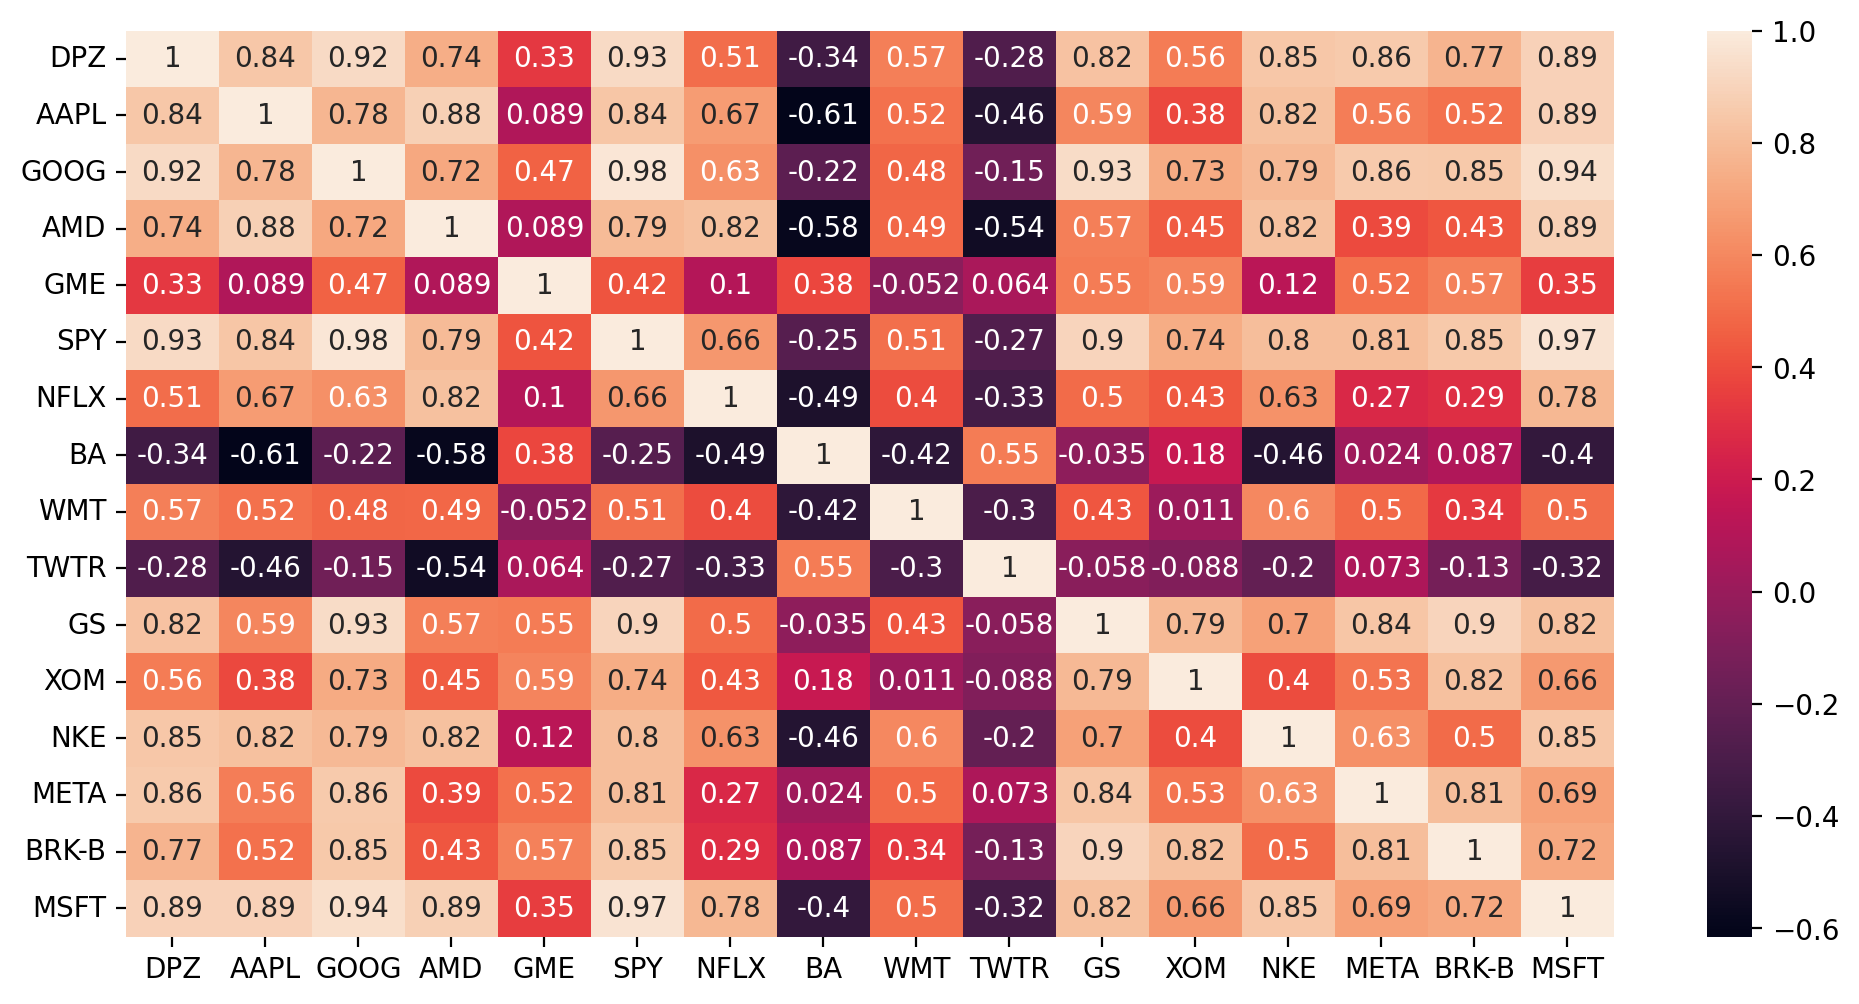

In [8]:
corr_matrix = d.corr()
figure(figsize=(12, 6), dpi=200)
sn.heatmap(corr_matrix, annot=True)
# find the most negative correlated pairs, BA and AAPL has -0.61 corr
# the flow would be: find high negative correlated pairs -> test stationariy
# then find high postive correlated pairs -> test

### 3. Set up parameters for stationarity testing, and create a function

In [21]:
# 3. set up parameters for stationarity testing, and set up a function
def ADF_Test(asset_a, asset_b):
    result = []
    asset_a = d[asset_a]
    asset_b = d[asset_b]
    spread = asset_a - asset_b
    ratio = asset_a/asset_b
    asset_a_ADF = round(adfuller(asset_a)[1],3) # for easy reading
    asset_b_ADF = round(adfuller(asset_b)[1],3)
    speard_ADF = round(adfuller(spread)[1],3)
    ratio_ADF = round(adfuller(ratio)[1],3)
    result.append([asset_a_ADF,asset_b_ADF,speard_ADF,ratio_ADF])
    return result

### 4. Create for-loop function to feed the stock data, generating it's ADF testing's p-value with others in the dataframe

In [22]:
table = pd.DataFrame()
for i in range(len(tickers)):
    result = []
    for j in range(len(tickers)):
        test = ADF_Test(tickers[i], tickers[j])
        result.append(test)
        df = pd.DataFrame(result, columns=['result'])
        np.seterr(divide='ignore') # add this code to turn off the error msg, can bring it back by setting argument as 'warn'
    table = pd.concat([table, df], axis=1)

In [23]:
# in this step, we are looking for p-value smaller than .05
table

,result,result,result,result,result,result,result,result,result,result,result,result,result,result,result,result
0,"[0.935, 0.935, nan, nan]","[0.964, 0.935, 0.834, 0.376]","[0.332, 0.935, 0.941, 0.028]","[0.935, 0.935, 0.763, 0.576]","[0.002, 0.935, 0.913, 0.002]","[0.766, 0.935, 0.829, 0.796]","[0.54, 0.935, 0.511, 0.571]","[0.209, 0.935, 0.966, 0.907]","[0.146, 0.935, 0.921, 0.788]","[0.425, 0.935, 0.966, 0.762]","[0.275, 0.935, 0.641, 0.213]","[0.03, 0.935, 0.942, 0.378]","[0.685, 0.935, 0.911, 0.497]","[0.456, 0.935, 0.929, 0.635]","[0.425, 0.935, 0.909, 0.797]","[0.879, 0.935, 0.743, 0.311]"
1,"[0.935, 0.964, 0.834, 0.354]","[0.964, 0.964, nan, nan]","[0.332, 0.964, 0.242, 0.157]","[0.935, 0.964, 0.385, 0.633]","[0.002, 0.964, 0.279, 0.004]","[0.766, 0.964, 0.2, 0.658]","[0.54, 0.964, 0.401, 0.628]","[0.209, 0.964, 0.872, 0.888]","[0.146, 0.964, 0.907, 0.842]","[0.425, 0.964, 0.991, 0.93]","[0.275, 0.964, 0.056, 0.209]","[0.03, 0.964, 0.907, 0.129]","[0.685, 0.964, 0.257, 0.154]","[0.456, 0.964, 0.466, 0.75]","[0.425, 0.964, 0.284, 0.643]","[0.879, 0.964, 0.517, 0.12]"
2,"[0.935, 0.332, 0.941, 0.016]","[0.964, 0.332, 0.242, 0.047]","[0.332, 0.332, nan, nan]","[0.935, 0.332, 0.497, 0.493]","[0.002, 0.332, 0.266, 0.001]","[0.766, 0.332, 0.866, 0.041]","[0.54, 0.332, 0.393, 0.056]","[0.209, 0.332, 0.816, 0.714]","[0.146, 0.332, 0.206, 0.011]","[0.425, 0.332, 0.881, 0.774]","[0.275, 0.332, 0.042, 0.152]","[0.03, 0.332, 0.605, 0.321]","[0.685, 0.332, 0.075, 0.026]","[0.456, 0.332, 0.322, 0.117]","[0.425, 0.332, 0.333, 0.272]","[0.879, 0.332, 0.948, 0.283]"
3,"[0.935, 0.935, 0.763, 0.561]","[0.964, 0.935, 0.385, 0.644]","[0.332, 0.935, 0.497, 0.559]","[0.935, 0.935, nan, nan]","[0.002, 0.935, 0.55, 0.017]","[0.766, 0.935, 0.134, 0.851]","[0.54, 0.935, 0.219, 0.741]","[0.209, 0.935, 0.908, 0.933]","[0.146, 0.935, 0.941, 0.882]","[0.425, 0.935, 0.917, 0.916]","[0.275, 0.935, 0.059, 0.743]","[0.03, 0.935, 0.901, 0.634]","[0.685, 0.935, 0.693, 0.807]","[0.456, 0.935, 0.57, 0.886]","[0.425, 0.935, 0.479, 0.82]","[0.879, 0.935, 0.224, 0.541]"
4,"[0.935, 0.002, 0.913, 0.0]","[0.964, 0.002, 0.279, 0.0]","[0.332, 0.002, 0.266, 0.001]","[0.935, 0.002, 0.55, 0.0]","[0.002, 0.002, nan, nan]","[0.766, 0.002, 0.775, 0.0]","[0.54, 0.002, 0.664, 0.0]","[0.209, 0.002, 0.083, 0.0]","[0.146, 0.002, 0.002, 0.0]","[0.425, 0.002, 0.009, 0.001]","[0.275, 0.002, 0.351, 0.0]","[0.03, 0.002, 0.0, 0.001]","[0.685, 0.002, 0.094, 0.0]","[0.456, 0.002, 0.399, 0.0]","[0.425, 0.002, 0.047, 0.0]","[0.879, 0.002, 0.897, 0.0]"
5,"[0.935, 0.766, 0.829, 0.79]","[0.964, 0.766, 0.2, 0.686]","[0.332, 0.766, 0.866, 0.081]","[0.935, 0.766, 0.134, 0.865]","[0.002, 0.766, 0.775, 0.002]","[0.766, 0.766, nan, nan]","[0.54, 0.766, 0.291, 0.202]","[0.209, 0.766, 0.964, 0.795]","[0.146, 0.766, 0.795, 0.245]","[0.425, 0.766, 0.968, 0.435]","[0.275, 0.766, 0.076, 0.029]","[0.03, 0.766, 0.872, 0.039]","[0.685, 0.766, 0.423, 0.237]","[0.456, 0.766, 0.548, 0.416]","[0.425, 0.766, 0.763, 0.356]","[0.879, 0.766, 0.406, 0.786]"
6,"[0.935, 0.54, 0.511, 0.609]","[0.964, 0.54, 0.401, 0.691]","[0.332, 0.54, 0.393, 0.175]","[0.935, 0.54, 0.219, 0.83]","[0.002, 0.54, 0.664, 0.003]","[0.766, 0.54, 0.291, 0.256]","[0.54, 0.54, nan, nan]","[0.209, 0.54, 0.727, 0.713]","[0.146, 0.54, 0.513, 0.346]","[0.425, 0.54, 0.653, 0.88]","[0.275, 0.54, 0.174, 0.09]","[0.03, 0.54, 0.502, 0.05]","[0.685, 0.54, 0.413, 0.274]","[0.456, 0.54, 0.568, 0.566]","[0.425, 0.54, 0.438, 0.358]","[0.879, 0.54, 0.403, 0.379]"
7,"[0.935, 0.209, 0.966, 0.962]","[0.964, 0.209, 0.872, 0.962]","[0.332, 0.209, 0.816, 0.847]","[0.935, 0.209, 0.908, 0.967]","[0.002, 0.209, 0.083, 0.002]","[0.766, 0.209, 0.964, 0.937]","[0.54, 0.209, 0.727, 0.738]","[0.209, 0.209, nan, nan]","[0.146, 0.209, 0.374, 0.425]","[0.425, 0.209, 0.084, 0.224]","[0.275, 0.209, 0.371, 0.574]","[0.03, 0.209, 0.338, 0.526]","[0.685, 0.209, 0.79, 0.868]","[0.456, 0.209, 0.694, 0.593]","[0.425, 0.209, 0.715, 0.929]","[0.879, 0.209, 0.923, 0.951]"
8,"[0.935,

In [25]:
# from the above table, I found DPZ and GOOG has high positive correlation
# and significant p-value <.05 to reject the null that the ratio of them is non-stationary
print(d['DPZ'].corr(d['GOOG']))
print(ADF_Test('DPZ','GOOG'))

0.9248038569875001
[[0.935, 0.332, 0.941, 0.016]]


### 5. Once confirmed the pair
- set up parameters: the pair's ratio, the ratio's Z-score, the short-term rolling mean of the ratio, and the long-term rolling mean, the long term rolling std, and the rolling Z-score

In [31]:
# set up parameters
ratio = d['DPZ']/d['GOOG']
ratio_zscore = (ratio - ratio.mean())/ratio.std()

ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()

std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20

### 6. Conduct Normality Test of the ratio_zscore
- the null hypothesis is that the sample drawn from a population is under normal dist
- if we have enough evidence, we can reject the null
- sicne the p-value of the ratio_zscore is not significant enough to reject the null, we assume it is under normal dist

In [37]:
# test the Z-score is under normal distribution or not
from scipy import stats
n, minmax, mean, var, skew, kurt = stats.describe(ratio_zscore)
mini, maxi = minmax #split the tuple minmax by unpacking
std = var**(1/2)
print(skew)
print(kurt)

1.2489174437482664
2.2546338336874276


(array([ 1., 11., 13., 28., 50., 55., 43., 11., 14.,  9.,  5.,  2.,  0.,
         4.,  7.]),
 array([-2.16544099, -1.79341928, -1.42139757, -1.04937586, -0.67735415,
        -0.30533244,  0.06668927,  0.43871098,  0.81073269,  1.1827544 ,
         1.55477611,  1.92679782,  2.29881953,  2.67084124,  3.04286295,
         3.41488466]),
 <BarContainer object of 15 artists>)

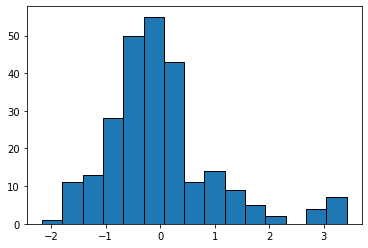

In [54]:
plt.hist(ratio_zscore, bins = 15, edgecolor='black')

Text(0.5, 1.0, 'normal distribution ')

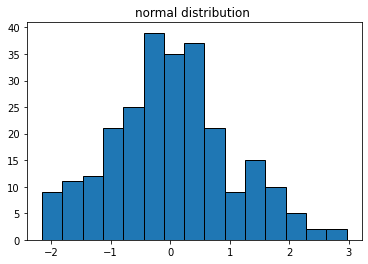

In [55]:
# use the mean and std of the ratio_Zscore to create a normal distribution
from scipy.stats import norm
x = norm.rvs(mean, std,n)
plt.hist(x,bins=15,edgecolor='black');
plt.title('normal distribution ')

In [42]:
x_test = stats.kurtosistest(x)
zscore_test = stats.kurtosistest(ratio_zscore)
print(f'{"     Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"ratio_zscore: {ratio_zscore[0]:13.2f}{ratio_zscore[1]:16.4f}")

# as the the p-value for ratio_zscore is not significant, we dont reject the null
# so we can assume it is under normal distribution

     Test statistic         p-value
     ------------------------------
x:             0.53          0.5978
ratio_zscore:          3.17          3.2263


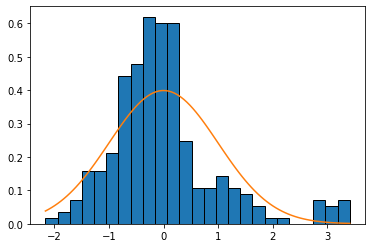

In [44]:
# Real distribution of ratio_zsore vs normal dist outlay

# density=True is to see the proportion, not the absolute value
plt.hist(ratio_zscore, bins=25, edgecolor='black', density=True)
# then we set a line follow normal distribution, using the stats of amzn
# make an array of 100 equally spaced datapoints
overlay=np.linspace(mini, maxi, 100)
plt.plot(overlay, norm.pdf(overlay, mean, std));

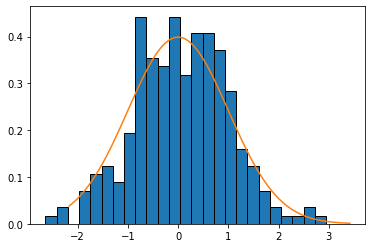

In [46]:
# simulating normal distribution of ratio_zsore vs normal dist outlay


plt.hist(x, bins =25, edgecolor='black', density = True)
# set up the normal dist line to check if x's dist follows normal or not
b = np.linspace(mini, maxi, 100)
plt.plot(b,stats.norm.pdf(b, mean, std));

### 6. Start the visualization for review 

Text(0.5, 1.0, 'Price Ratio between DPZ and GOOG')

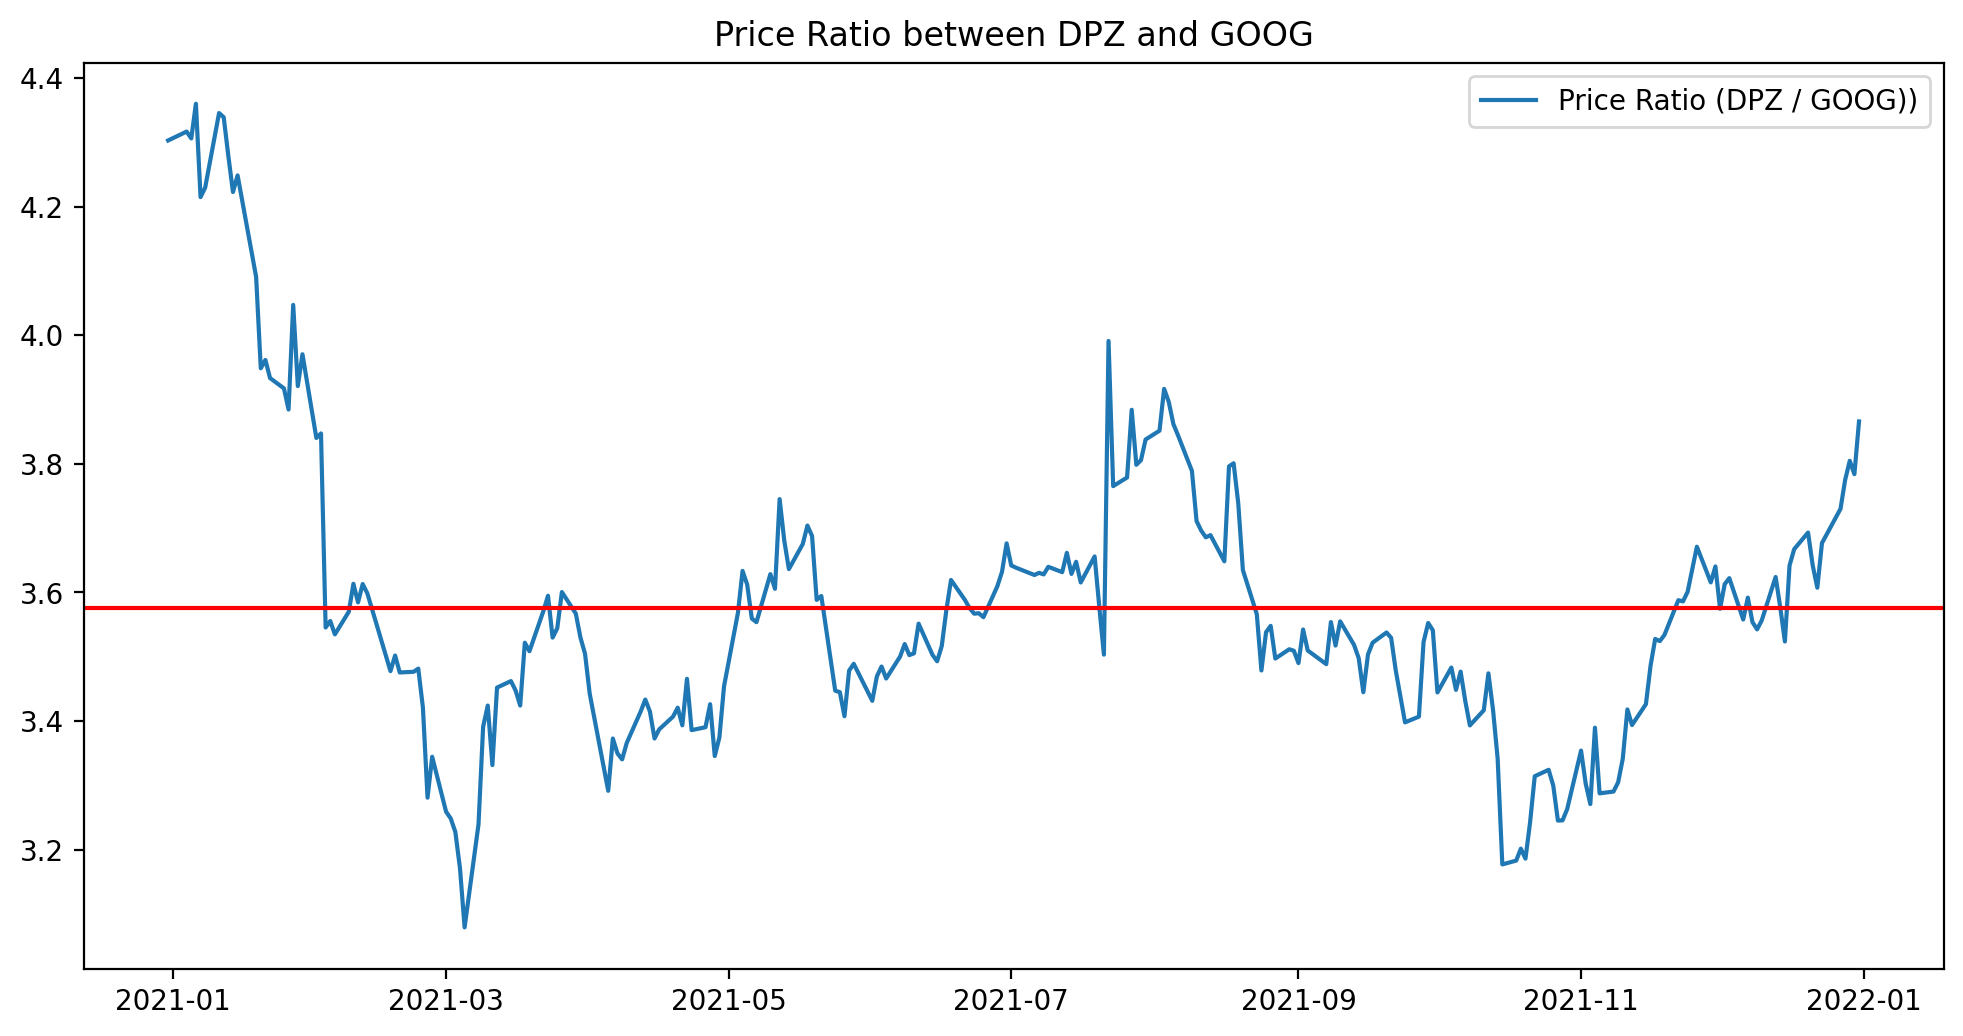

In [28]:
figure(figsize=(12, 6), dpi=200)
plt.plot(ratio, label = 'Price Ratio (DPZ / GOOG))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between DPZ and GOOG")

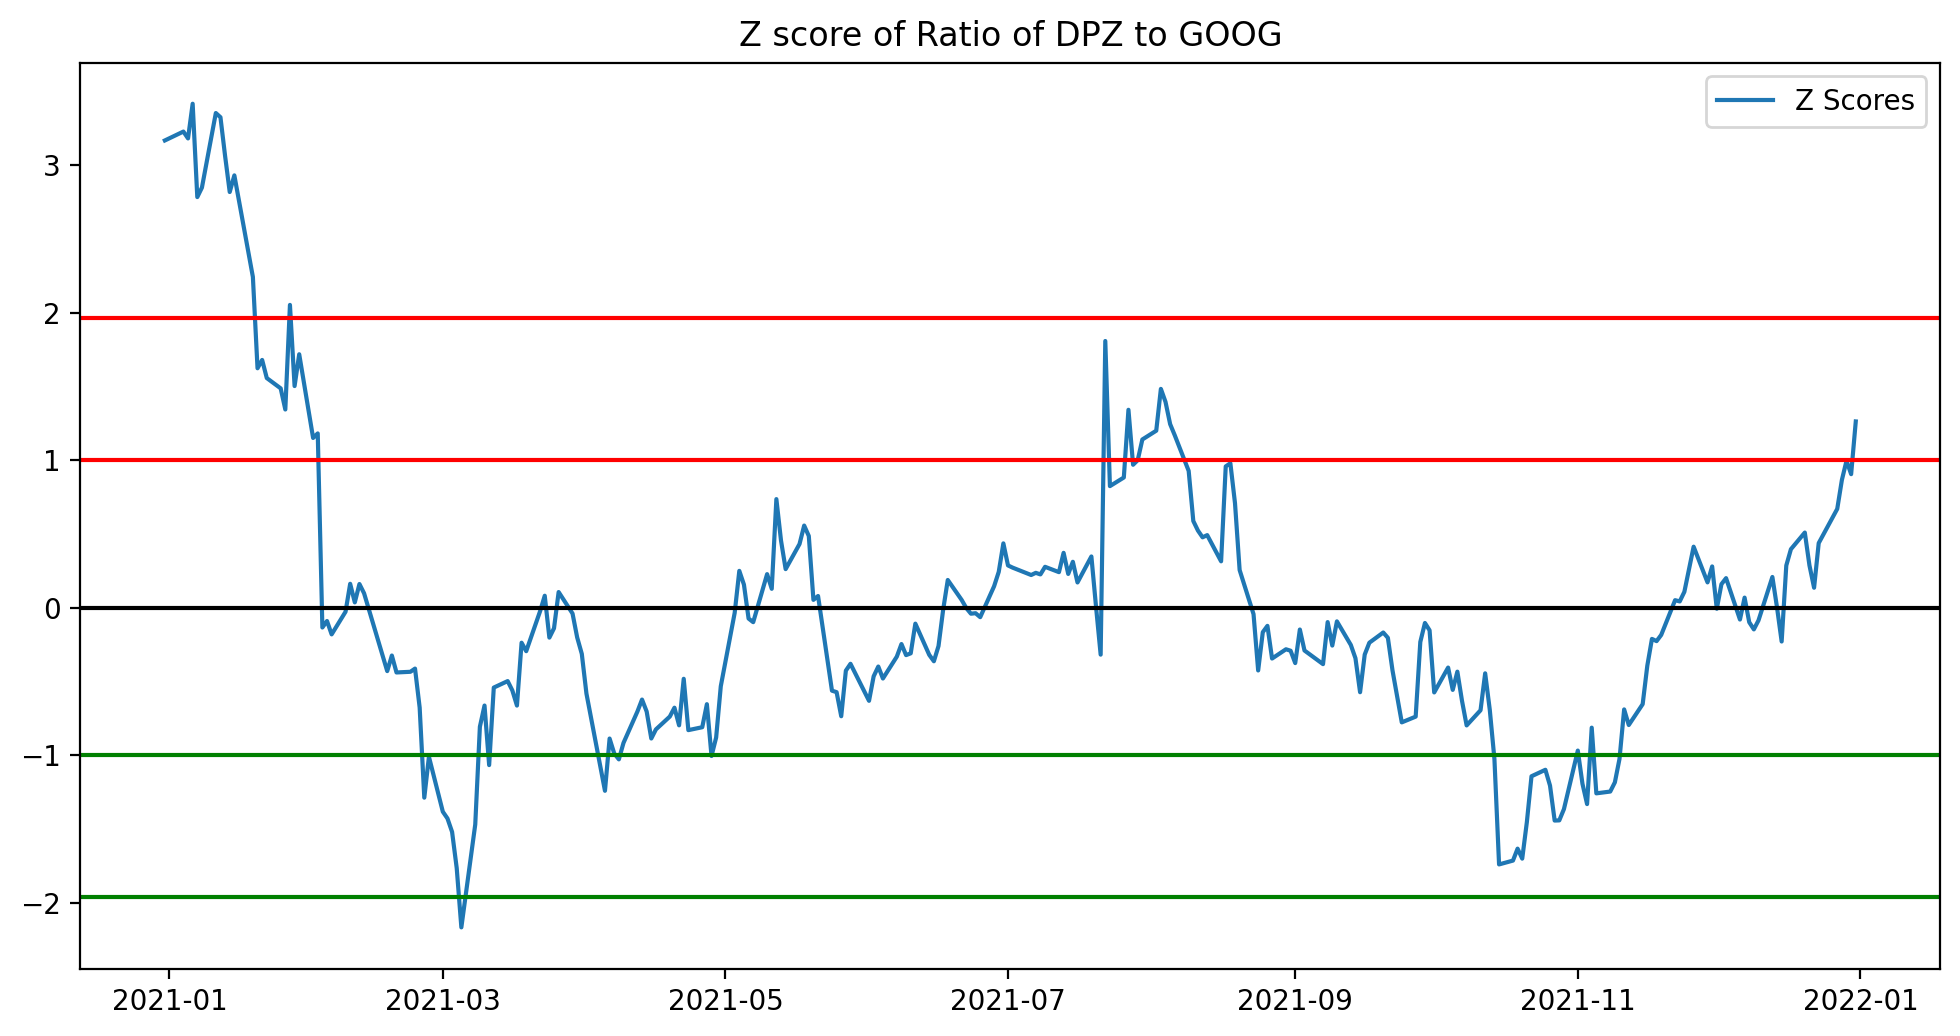

In [48]:
figure(figsize=(12, 6), dpi=200)
plt.plot(ratio_zscore, label = "Z Scores")
plt.axhline(ratio_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.96, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.96, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of DPZ to GOOG')
plt.show()

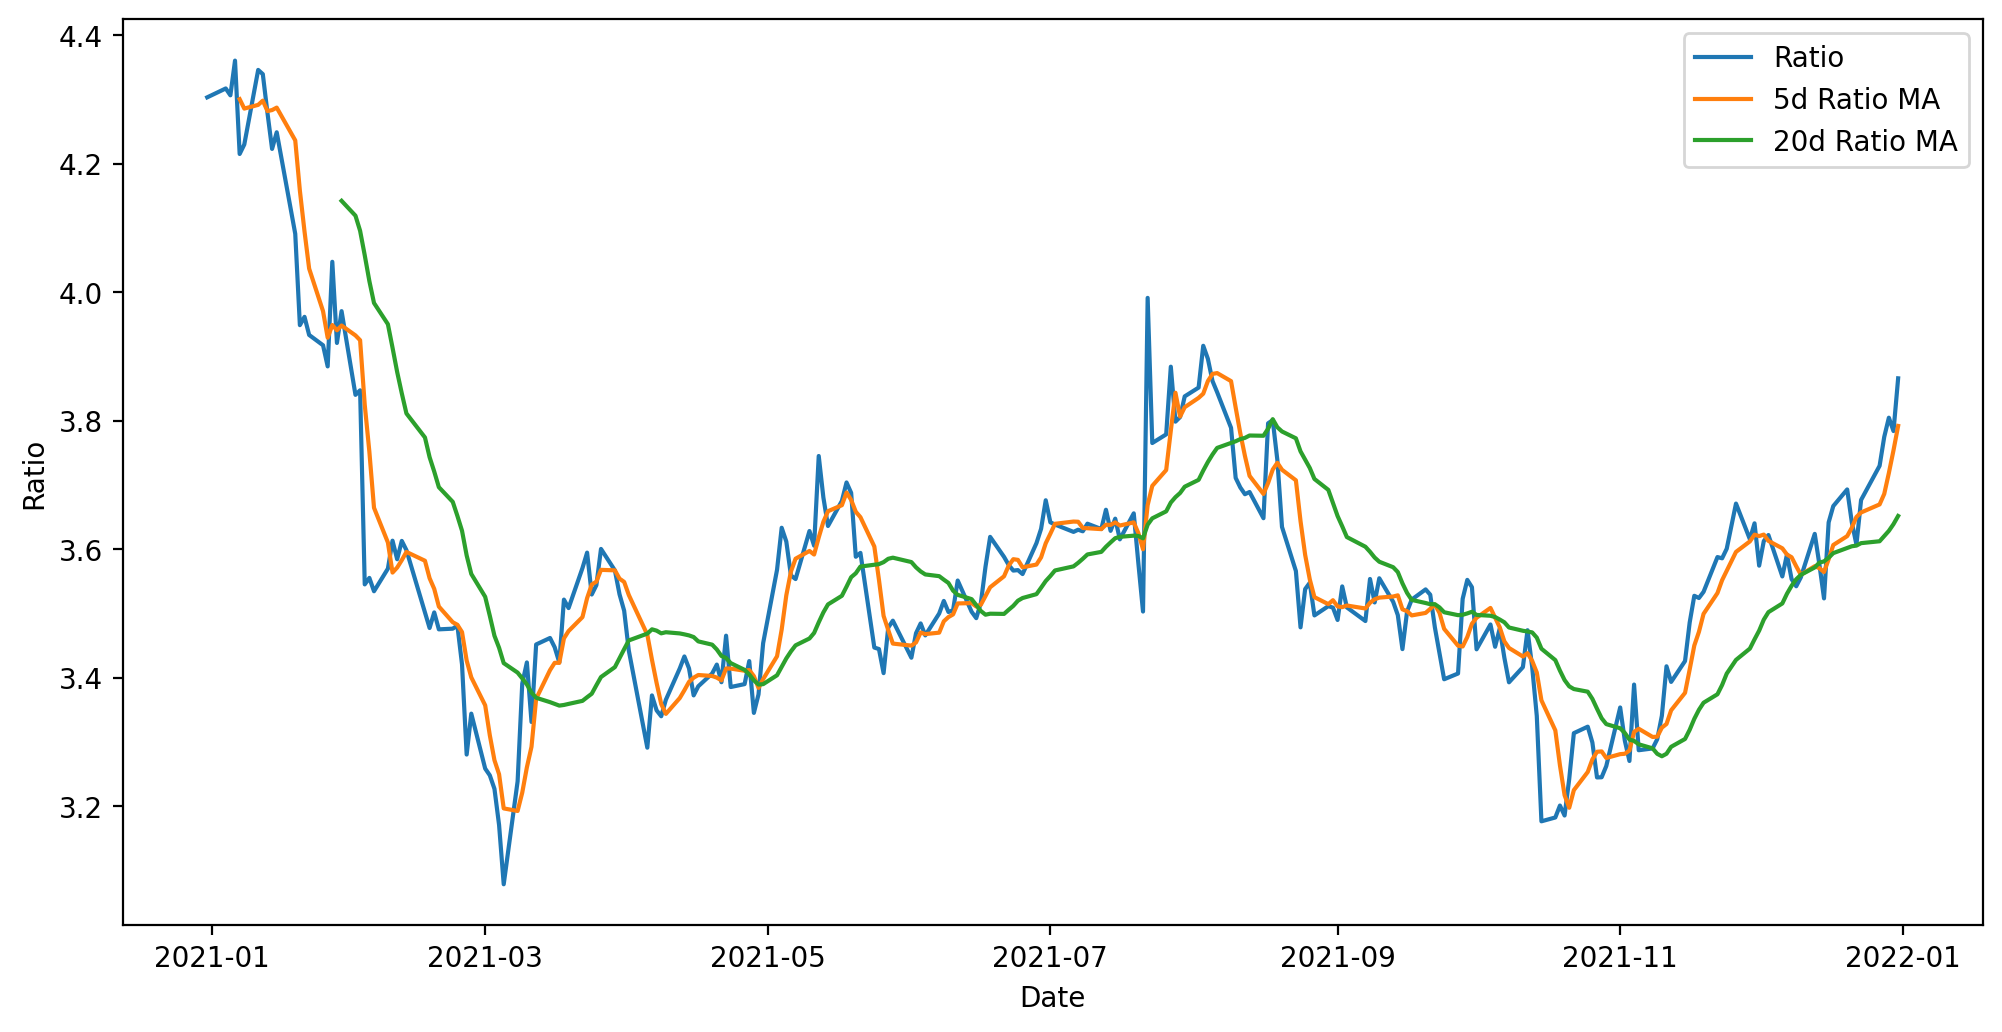

In [49]:
figure(figsize=(12, 6), dpi=200)
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

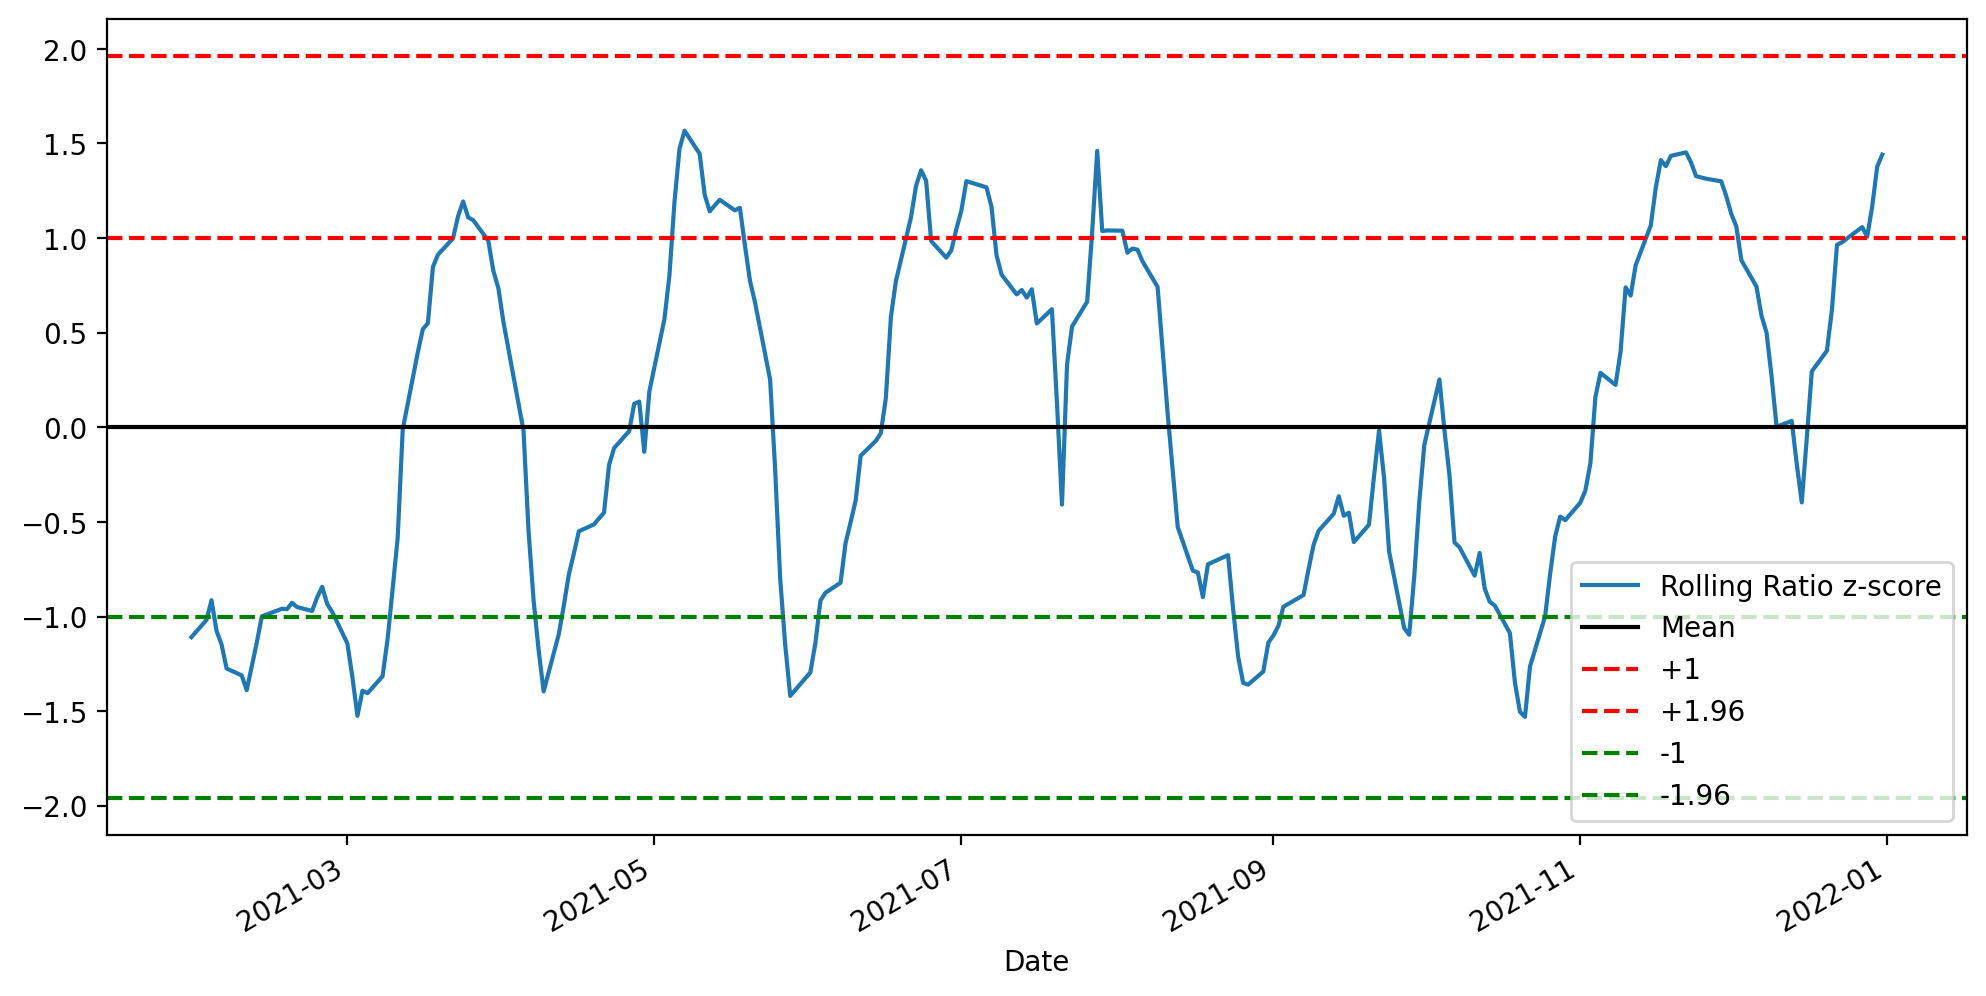

In [50]:
figure(figsize=(12, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.96, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.96, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.96','-1','-1.96'])
plt.show()

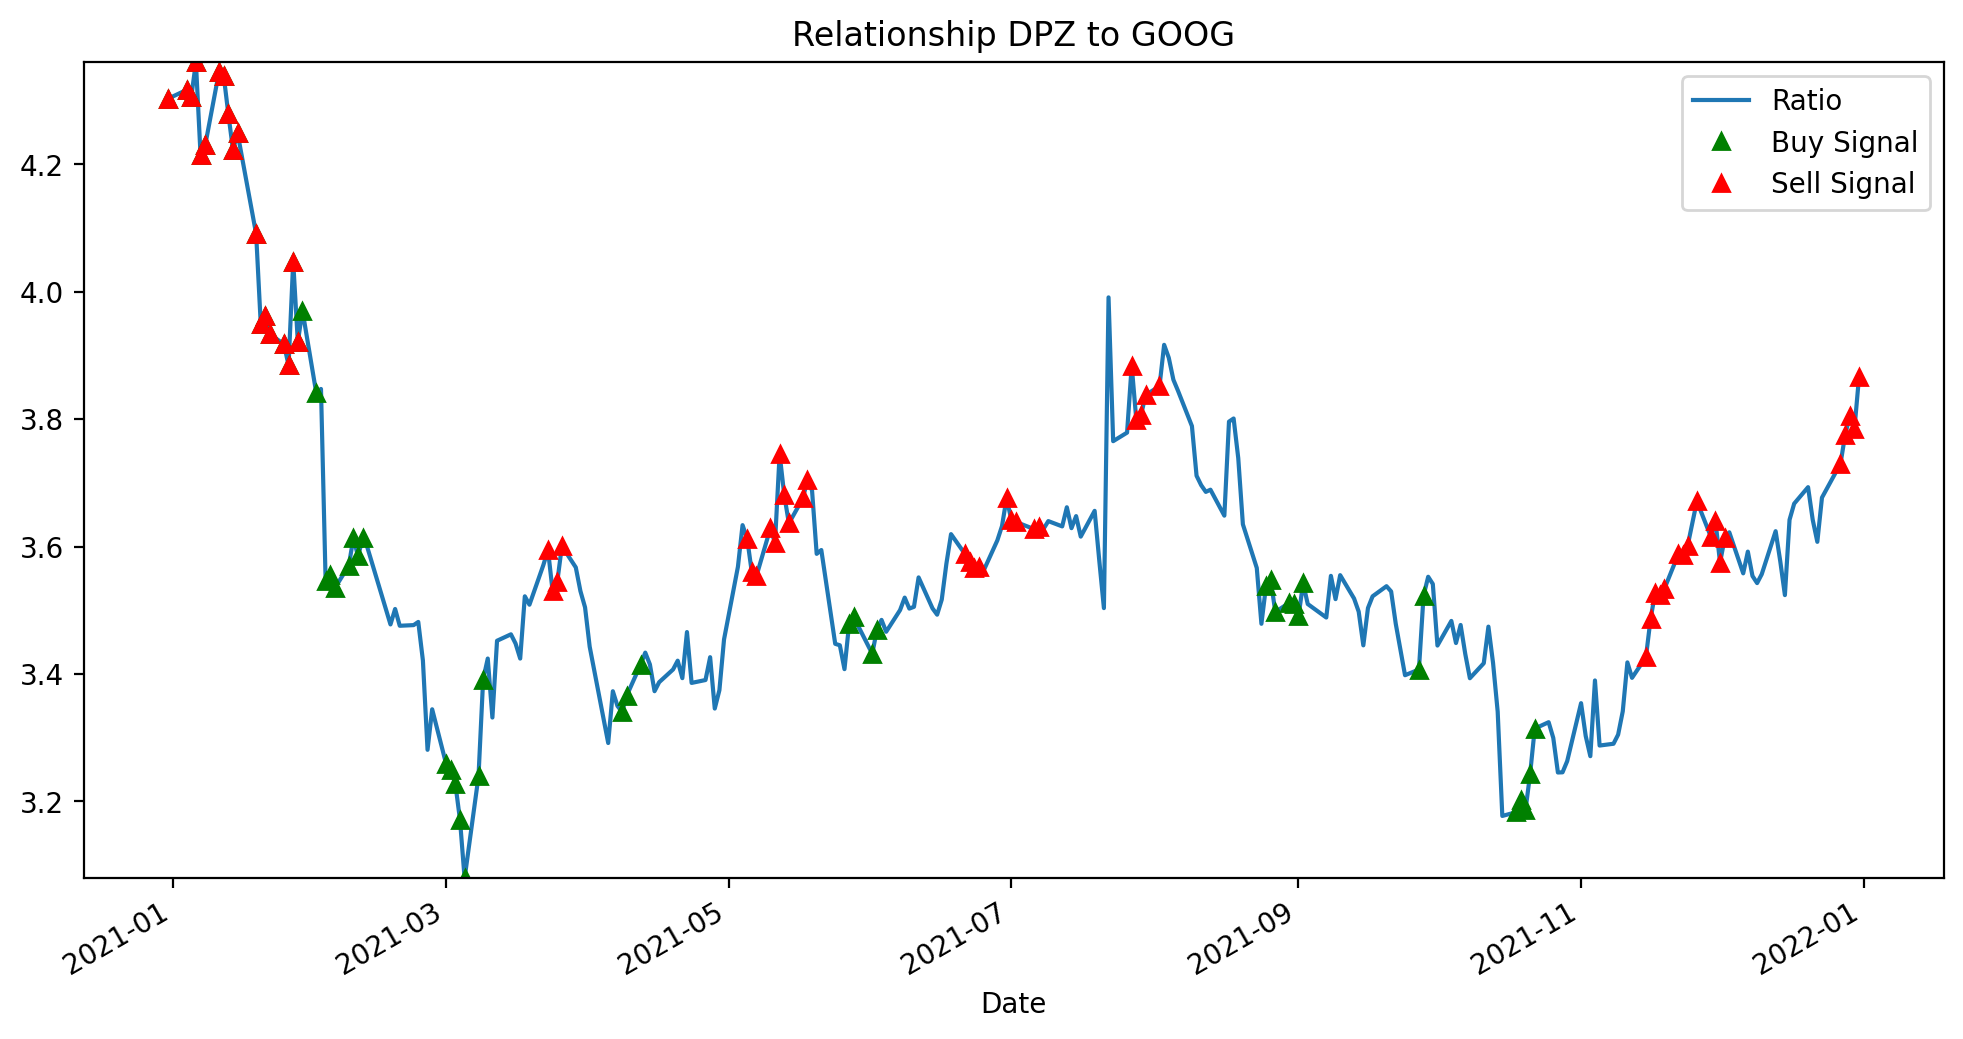

In [52]:
figure(figsize=(12, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship DPZ to GOOG')
plt.show()